## Подготовка.

In [1]:
from avengers import Jarvis, Vision, Tony

## Загрузка

In [2]:
v = Vision('SBRF')

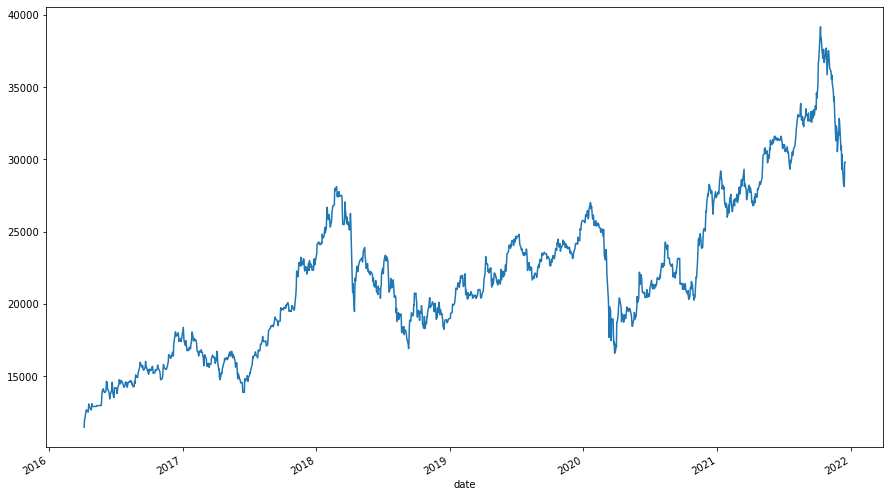

In [3]:
v.plot()

In [4]:
v.names_list

['SBRF-3.17',
 'SBRF-6.17',
 'SBRF-9.17',
 'SBRF-12.17',
 'SBRF-3.18',
 'SBRF-6.18',
 'SBRF-9.18',
 'SBRF-12.18',
 'SBRF-3.19',
 'SBRF-6.19',
 'SBRF-9.19',
 'SBRF-12.19',
 'SBRF-3.20',
 'SBRF-6.20',
 'SBRF-9.20',
 'SBRF-12.20',
 'SBRF-3.21',
 'SBRF-6.21',
 'SBRF-9.21',
 'SBRF-12.21']

In [5]:
v.objects_dict['GAZR-3.20'].data.plot()

KeyError: 'GAZR-3.20'

In [ ]:
v.objects_dict['GAZR-6.20'].data.plot()

In [ ]:
v.objects_dict['GAZR-9.20'].data.plot()

In [ ]:
v.objects_dict['GAZR-12.20'].qrt_opt.info()

In [ ]:
v = '160317'

In [ ]:
str(int(v) - 10000)